# Strategies and Panel Data

When working with panel data, we have two options.

1. We can apply a strategy to all stocks in the panel data.

1. We can subset a particular stock, effectively obtaining time series data for that single asset. From here we can use the same method we did in the previous notebook. This has the advantage of parameter optimisation, which we'll see at the end of this notebook.

Let's start with the *one strategy for all stocks* approach, applying the SMA crossover strategy.

First, imports and preparing the dataframe.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [77]:
df = pd.read_csv("data/top_six_2020_2025.csv")
df.DlyCalDt = pd.to_datetime(df.DlyCalDt, dayfirst=True)

### Exercise: Recycling Code

Whenever we're going to be repeating an operation, it is usually a good idea (and sometimes necessary) to create our own function. The code below is correct, but out-of-order. Re-arrange the below into a function called `calculate_sma`, which will take three inputs:
* a data frame that contains a prccd column
* a fast window size
* a slow window size

The function will add as features:
* slow and fast moving averages based on the prccd price
* buy/sell signals
* a position

In [78]:
def calculate_sma(dfi, fast_window, slow_window):
    dfi["FastMA"] = dfi.DlyClose.rolling(window=fast_window).mean()
    dfi["SlowMA"] = dfi.DlyClose.rolling(window=slow_window).mean()

    dfi["Signal"] = np.where(dfi.FastMA > dfi.SlowMA, 1, -1)
    dfi.Signal = np.where(dfi.SlowMA.isna(), 0, dfi.Signal)

    dfi["Position"] = dfi.Signal.shift()

    return dfi

  # we need these because of panel data, we have many companies 

With the function done, we can apply it groupwise to the stocks in our panel data by iterating over the groups.

In [79]:
FAST, SLOW = 50, 200

# create some groups, group by each security
grouped = df.groupby("Ticker") # the variable grouped have two things

groups = []
for name, group in grouped:
    signals = calculate_sma(group, FAST, SLOW)
    groups.append(signals)

df = pd.concat(groups)
df

,DlyCalDt,Ticker,DlyClose,DlyHigh,DlyLow,DlyOpen,DlyVolume,FastMA,SlowMA,Signal,Position
0,2020-01-02,AAPL,72.620834,72.681281,71.373211,71.627084,135480400,NaN,NaN,0,NaN
1,2020-01-03,AAPL,71.914818,72.676447,71.689957,71.847118,146322800,NaN,NaN,0,0.0
2,2020-01-06,AAPL,72.487839,72.526526,70.783241,71.034702,118387200,NaN,NaN,0,0.0
3,2020-01-07,AAPL,72.146927,72.753808,71.926900,72.497514,108872000,NaN,NaN,0,0.0
4,2020-01-08,AAPL,73.307503,73.609737,71.849525,71.849525,132079200,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7537,2024-12-23,NVDA,139.657150,139.777134,135.107566,136.267463,176053500,139.697961,116.614786,1,1.0
7538,2024-12-24,NVDA,140.207108,141.886946,138.637245,139.987127,105157000,139.741147,116.887092,1,1.0
7539,2024-12-26,NVDA,139.917130,140.837058,137.717335,139.687155,116205600,139.907913,117.127264,1,1.0
7540,2024-12-27,NVDA,136.997391,139.007216,134.697615,138.537258,170582600,139.933897,117.357960,1,1.0


Then it's a matter of calculating the cumulative returns as we've done before.... nearly. Remember that we have grouped data here!

In [80]:
df["Returns"] = df.groupby("Ticker").DlyClose.pct_change()
df["Strategy"] = df.Position * df.Returns
# don't need to group here
df["BuyHold"] = (1 + df.Returns).groupby(df.Ticker).cumprod() - 1
df["MACS"] = (1 + df.Strategy).groupby(df.Ticker).cumprod() - 1
print(df.tail(1)[["Ticker", "BuyHold", "MACS"]]) #in vidia's performance 

     Ticker    BuyHold      MACS
7541   NVDA  22.019699  8.088725


### Exercise: Data Display

Can you produce a data frame with the end-of-period market and strategy cumulative return for each stock?

In [81]:
# need to use aggregate to do it, for each ticker tells you to groupby
df.groupby("Ticker").agg(
    {"BuyHold": "last", "MACS": "last"} # the last give the final return for each stock (cumulative)
)


,BuyHold,MACS
Ticker,,
AAPL,2.464475,-0.087545
AMZN,1.331916,0.259688
GOOGL,1.804648,2.344505
META,1.829147,3.836335
MSFT,1.765267,0.810626
NVDA,22.019699,8.088725


## Single Stock

Let's subset META (Facebook) and use that for the rest of the notebook.

In [82]:
meta = df.groupby("Ticker").get_group("META").copy()
meta.set_index("DlyCalDt", inplace=True)
meta

,Ticker,DlyClose,DlyHigh,DlyLow,DlyOpen,DlyVolume,FastMA,SlowMA,Signal,Position,Returns,Strategy,BuyHold,MACS
DlyCalDt,,,,,,,,,,,,,,
2020-01-02,META,208.795944,208.805892,205.302415,205.780159,12077100,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2020-01-03,META,207.691147,209.413027,205.979214,206.238004,11188400,NaN,NaN,0,0.0,-0.005291,-0.000000,-0.005291,0.000000
2020-01-06,META,211.602722,211.781871,205.551241,205.730389,17058900,NaN,NaN,0,0.0,0.018834,0.000000,0.013443,0.000000
2020-01-07,META,212.060547,213.573421,210.756694,211.821682,14912400,NaN,NaN,0,0.0,0.002164,0.000000,0.015635,0.000000
2020-01-08,META,214.210419,215.225638,211.612661,212.000831,13475000,NaN,NaN,0,0.0,0.010138,0.000000,0.025932,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,META,599.316772,600.555721,585.728886,589.075884,10205800,585.241262,524.072216,1,1.0,0.024947,0.024947,1.870347,3.906765
2024-12-24,META,607.209778,607.449555,598.747336,602.184220,4726100,585.597064,524.699104,1,1.0,0.013170,0.013170,1.908149,3.971387
2024-12-26,META,602.813660,605.761050,598.407607,604.941771,6081400,585.947802,525.223505,1,1.0,-0.007240,-0.007240,1.887095,3.935395


### Exercise: BB Breakout

Implement an Bollinger Bands Breakout strategy and backtest it on META.

- First create high and low Bollinger Bands as usual
- Then generate signals as follows:
  - Buy (+1) when the close price crosses above the upper band
    - Hold the position until a signal change
  - Sell (-1) when the close price crosses under the lower band
    - Hold the position until a signal change
- Generate positions
- Calculate the strategy returns and cumulative strategy returns
- Report and plot the cumulative strategy and market returns

**HINT** You can create an empty column by assigning it `np.nan`

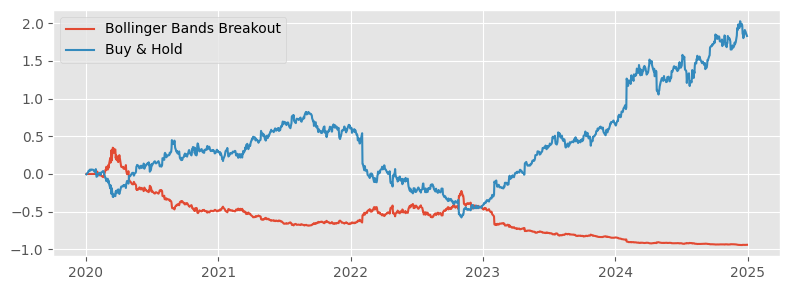

In [83]:
WINDOW = 20
meta["SMA"] = meta.DlyClose.rolling(WINDOW).mean()
meta["DEV"] = meta.DlyClose.rolling(WINDOW).std()
meta["LowB"] = meta.SMA + (2 * meta.DEV)
meta["HighB"] = meta.SMA - (2 * meta.DEV)

#hold the position until signial change
meta["Signal"] = np.nan
meta.Signal = np.where(meta.DlyClose > meta.HighB, 1, meta.Signal)
meta.Signal = np.where(meta.DlyClose < meta.LowB, -1, meta.Signal)
meta.Signal = meta.Signal.ffill()
meta.Signal = meta.Signal.fillna(0)

# cumulative returns
meta["Position"] = meta.Signal.shift()
meta["Strategy"] = meta.Returns * meta.Position
meta["Breakout"] = (1 + meta.Strategy).cumprod() - 1 # This is a new trading staretagy 

meta.tail(1)[["Ticker", "BuyHold", "MACS", "Breakout"]] # compare the three strategy 

plt.figure(figsize=(8, 3))
plt.plot(meta.Breakout, label = "Bollinger Bands Breakout")
plt.plot(meta.BuyHold, label="Buy & Hold")
plt.legend()
plt.tight_layout()

## Parameter Optimisation

Parameter optimisation involves getting the best out of a strategy. The *parameters* in our strategy are the window size of the fast SMA and slow SMA. We used 50 and 200 days, but could try different combinations to see if they give better results.

Common **fast** window sizes include 7, 20, 50 and common **slow** window sizes include 50, 100, 200.

However, beware of overfitting! When a model fits our historical data too closely, it can perform poorly in future real-world scenarios.

### Exercise: Which windows?

The code below implements an Exponential Moving Average Crossover Strategy. Similar to our SMA strategy, but calculating the rolling mean in a different way that takes recent prices into greater consideration.

Unfortunately, the implementation with the window sizes below does not perform well. Modify the code below to perform a parameter optimisation on the strategy. Your code should be able to test 3 fast window sizes and 3 slow window sizes in combination.

Can you find a combination of window sizes that sees this EMA strategy outperform the simple Bollinger Band strategy above?

In [86]:
ema = meta.copy()

## MODIFY THIS CODE

fast_window, slow_window = 50, 200

ema["FastEMA"] = ema.DlyClose.ewm(span=fast_window, adjust=False).mean()
ema["SlowEMA"] = ema.DlyClose.ewm(span=slow_window, adjust=False).mean()

ema["Signal"] = np.where(ema.FastEMA > ema.SlowEMA, 1, -1)
ema["Signal"] = np.where(ema.SlowEMA.isna(), 0, ema.Signal)

ema["Position"] = ema.Signal.shift()
ema["StratRet"] = ema.Position * ema.Returns
ema["Strategy"] = (1 + ema.StratRet).cumprod() - 1

print("Short window:", fast_window, "Long window:", slow_window)
print("Cumulative Strategy Return is", ema.Strategy.iloc[-1])

Short window: 50 Long window: 200
Cumulative Strategy Return is 1.594839947209607
